## Identifying Duplicate Questions

Over 100 million people visit Quora every month, so it's no surprise that many people ask similar (or the same) questions. Various questions with the same intent can cause people to spend extra time searching for the best answer to their question, and results in members answering multiple versions of the same question. Quora uses random forest to identify duplicated questions to provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
Follow the steps outlined below to build the appropriate classifier model. 


Steps:
- Download data
- Exploration
- Cleaning
- Feature Engineering
- Modeling

By the end of this project you should have **a presentation that describes the model you built** and its **performance**. 


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

from nltk.corpus import stopwords
import os
from nltk.corpus import stopwords
from sklearn.manifold import TSNE
from os import path

plt.rcParams['figure.dpi'] = 120
plt.rcParams['savefig.dpi'] = 120


import warnings
warnings.filterwarnings('ignore')

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import string
from fuzzywuzzy import fuzz
import distance

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import spacy
from tqdm import tqdm
import csv

2022-04-08 15:06:43.508446: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/openmpi/lib:/usr/local/lib:/usr/lib:/usr/local/openmpi/lib:/usr/local/lib:/usr/lib:
2022-04-08 15:06:43.508476: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
nltk.download('punkt')
nltk.download('stopwords')
pd.set_option('display.max_columns', None)

[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
df = pd.read_csv("train.csv")

#### Note
There is no designated test.csv file. The train.csv file is the entire dataset. Part of the data in the train.csv file should be set aside to act as the final testing data.

### Exploratory Data Analysis

In [4]:
df

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
...,...,...,...,...,...,...
404285,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0
404286,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1
404287,404287,537928,537929,What is one coin?,What's this coin?,0
404288,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0


In [5]:
df.shape

(404290, 6)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


#### check for null value

In [7]:
df[df.isnull().any(axis=1)]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [8]:
df.shape

(404290, 6)

In [9]:
df = df.dropna()
df.shape

(404287, 6)

#### Distribution of target variable

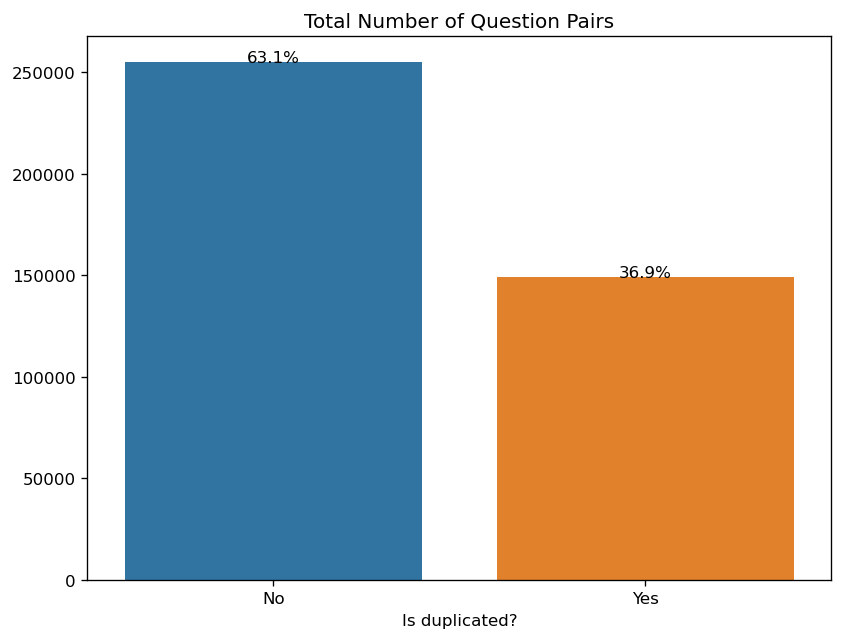

In [10]:
plt.figure(figsize=(8,6))
cnt = df['is_duplicate'].value_counts()
percentage = [cnt[0]/cnt.sum()*100, cnt[1]/cnt.sum()*100]
ax = sns.barplot(['No', 'Yes'],y=cnt.values)
plt.title('Total Number of Question Pairs')
plt.xlabel('Is duplicated?')

patches = ax.patches
for i in range(len(patches)):
    x = patches[i].get_x() + patches[i].get_width()/2
    y = patches[i].get_height()+.05
    ax.annotate('{:.1f}%'.format(percentage[i]), (x, y), ha='center')
plt.show()

#### Total number of questions

In [11]:
qids = pd.Series(df.qid2.tolist() + df.qid1.tolist())
total_question = len(np.unique(qids))

In [12]:
total_question

537929

In [13]:
df_q1 = df[['qid1', 'question1']]
df_q1 = df_q1.rename(columns={'qid1': 'qid', 'question1': 'question'})
df_q2 = df[['qid2', 'question2']]
df_q2 = df_q2.rename(columns={'qid2': 'qid', 'question2': 'question'})
df_tq = pd.concat([df_q1, df_q2], axis=0)
df_tq = df_tq.drop_duplicates()

In [14]:
len(df_tq)

537929

In [15]:
x = df_tq['question'].str.split().apply(len)

In [16]:
x.mean()

11.402279854776374

Text(0.5, 0, 'No of words')

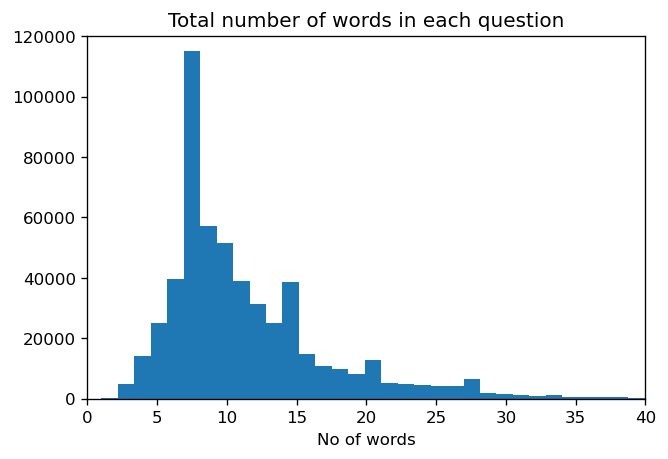

In [17]:
plt.hist(x, bins=200) 
plt.axis([0, 40, 0, 120000]) 
plt.title('Total number of words in each question')
plt.xlabel('No of words')

Text(0, 0.5, 'No of questions')

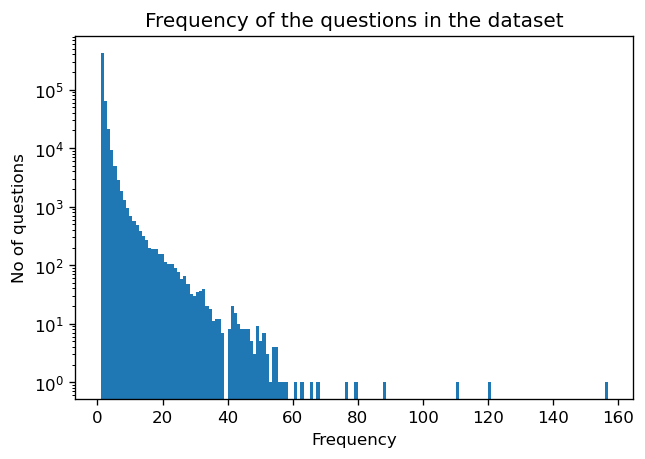

In [20]:
cnt = qids.value_counts()
plt.hist(cnt, bins=160) 
#plt.axis([0,160, 0, 100]) 
plt.yscale('log')
plt.title('Frequency of the questions in the dataset')
plt.xlabel('Frequency')
plt.ylabel('No of questions')

In [21]:
def common_wrd(data):
    x = set(data['question1'].lower().strip().split(" ")) 
    y = set(data['question2'].lower().strip().split(" "))
    return 1.0 * len(x & y)

def total(data):
    set1 = set(data['question1'].lower().strip().split(" "))
    set2 = set(data['question2'].lower().strip().split(" "))
    return 1.0 * (len(set1) + len(set2))

def word_share(data):
    x = data['word_common']/data['word_total']
    return  x

df['freq_qid1'] = df['qid1'].apply(lambda x: cnt[x])
df['freq_qid2'] = df['qid2'].apply(lambda x: cnt[x])
df['q1len'] = df['question1'].apply(lambda x: len(x))
df['q2len'] = df['question2'].apply(lambda x: len(x))
df['q1_n_words'] = df['question1'].apply(lambda x: len(x.split(" ")))
df['q2_n_words'] = df['question2'].apply(lambda x: len(x.split(" ")))
df['word_common'] = df.apply(common_wrd,axis=1)
df['word_total'] = df.apply(total,axis=1)
df['word_share'] = df.apply(word_share,axis=1)
df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

In [22]:
df

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_common,word_total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,2,51,88,8,13,4.0,20.0,0.200000,6,2
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404285,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0,2,2,85,79,14,13,11.0,25.0,0.440000,4,0
404286,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1,12,12,41,42,8,9,5.0,16.0,0.312500,24,0
404287,404287,537928,537929,What is one coin?,What's this coin?,0,1,1,17,17,4,3,1.0,7.0,0.142857,2,0
404288,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0,1,1,94,127,17,25,1.0,40.0,0.025000,2,0


### Cleaning

- Tokenization
- Stopwords cleaning
- Removing punctuation
- Normalizing
- Stemming

In [23]:
df_model = df.copy()

In [24]:
stop_words = set(stopwords.words('english'))
porter = PorterStemmer()

def remove_punctuation(words):
    table = str.maketrans('', '', string.punctuation)
    return [word.translate(table) for word in words] 

def lower_case(words):
    return [word.lower() for word in words]

def stopwords_cleaning(words):
    return [word for word in words if not word in stop_words]

def stemming(words):
    return [porter.stem(word) for word in words]

In [25]:
# Tokenization
df_model['question1_tokenize'] = df['question1'].apply(word_tokenize)
df_model['question2_tokenize'] = df['question2'].apply(word_tokenize)

In [26]:
# Removing punctuation
df_model['question1_tokenize'] = df_model['question1_tokenize'].apply(remove_punctuation)
df_model['question2_tokenize'] = df_model['question2_tokenize'].apply(remove_punctuation)

In [27]:
# Convert to lower case
df_model['question1_tokenize'] = df_model['question1_tokenize'].apply(lower_case)
df_model['question2_tokenize'] = df_model['question2_tokenize'].apply(lower_case)

In [28]:
# Stopwords cleaning
df_model['question1_tokenize'] = df_model['question1_tokenize'].apply(stopwords_cleaning)
df_model['question2_tokenize'] = df_model['question2_tokenize'].apply(stopwords_cleaning)

In [29]:
# Stemming
df_model['question1_tokenize'] = df_model['question1_tokenize'].apply(stemming)
df_model['question2_tokenize'] = df_model['question2_tokenize'].apply(stemming)

In [30]:
df_model

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_common,word_total,word_share,freq_q1+q2,freq_q1-q2,question1_tokenize,question2_tokenize
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0,"[step, step, guid, invest, share, market, indi...","[step, step, guid, invest, share, market, ]"
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,2,51,88,8,13,4.0,20.0,0.200000,6,2,"[stori, kohinoor, , kohinoor, , diamond, ]","[would, happen, indian, govern, stole, kohinoo..."
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0,"[increas, speed, internet, connect, use, vpn, ]","[internet, speed, increas, hack, dn, ]"
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0,"[mental, lone, , solv, ]","[find, remaind, , math, , 23, , 24, , , math, ..."
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2,"[one, dissolv, water, quikli, sugar, , salt, ,...","[fish, would, surviv, salt, water, ]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404285,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0,2,2,85,79,14,13,11.0,25.0,0.440000,4,0,"[mani, keyword, racket, program, languag, late...","[mani, keyword, perl, program, languag, latest..."
404286,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1,12,12,41,42,8,9,5.0,16.0,0.312500,24,0,"[believ, life, death, ]","[true, life, death, ]"
404287,404287,537928,537929,What is one coin?,What's this coin?,0,1,1,17,17,4,3,1.0,7.0,0.142857,2,0,"[one, coin, ]","[coin, ]"
404288,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0,1,1,94,127,17,25,1.0,40.0,0.025000,2,0,"[approx, annual, cost, live, studi, uic, chica...","[littl, hairfal, problem, want, use, hair, sty..."


In [31]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in stop_words])
    q2_words = set([word for word in q2_tokens if word not in stop_words])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in stop_words])
    q2_stops = set([word for word in q2_tokens if word in stop_words])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + 0.0001)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + 0.0001)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + 0.0001)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + 0.0001)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + 0.0001)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + 0.0001)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [32]:
extract_features(df_model)

token features...
fuzzy features..


,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_common,word_total,word_share,freq_q1+q2,freq_q1-q2,question1_tokenize,question2_tokenize,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0,"[step, step, guid, invest, share, market, indi...","[step, step, guid, invest, share, market, ]",0.833319,0.714276,0.999980,0.999980,0.833326,0.714281,0,1,2,13.0,100,93,93,98,0.965517
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,2,51,88,8,13,4.0,20.0,0.200000,6,2,"[stori, kohinoor, , kohinoor, , diamond, ]","[would, happen, indian, govern, stole, kohinoo...",0.599988,0.299997,0.499975,0.333322,0.499994,0.307690,0,1,5,10.5,86,63,66,73,0.442308
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0,"[increas, speed, internet, connect, use, vpn, ]","[internet, speed, increas, hack, dn, ]",0.333328,0.249997,0.249994,0.166664,0.299997,0.214284,0,1,4,12.0,63,63,43,41,0.150000
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0,"[mental, lone, , solv, ]","[find, remaind, , math, , 23, , 24, , , math, ...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,2,10.0,28,24,9,20,0.039216
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2,"[one, dissolv, water, quikli, sugar, , salt, ,...","[fish, would, surviv, salt, water, ]",0.166664,0.090908,0.999900,0.499975,0.285710,0.153845,0,1,6,10.0,67,47,35,54,0.150000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404285,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0,2,2,85,79,14,13,11.0,25.0,0.440000,4,0,"[mani, keyword, racket, program, languag, late...","[mani, keyword, perl, program, languag, latest...",0.624992,0.624992,0.999975,0.799984,0.692302,0.642853,1,1,1,13.5,97,88,91,84,0.387500
404286,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1,12,12,41,42,8,9,5.0,16.0,0.312500,24,0,"[believ, life, death, ]","[true, life, death, ]",0.499988,0.499988,0.749981,0.599988,0.624992,0.555549,1,0,1,8.5,79,69,72,76,0.642857
404287,404287,537928,537929,What is one coin?,What's this coin?,0,1,1,17,17,4,3,1.0,7.0,0.142857,2,0,"[one, coin, ]","[coin, ]",0.499975,0.333322,0.000000,0.000000,0.333322,0.249994,1,0,1,3.5,75,75,75,76,0.333333
404288,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0,1,1,94,127,17,25,1.0,40.0,0.025000,2,0,"[approx, annual, cost, live, studi, uic, chica...","[littl, hairfal, problem, want, use, hair, sty...",0.000000,0.000000,0.142855,0.124998,0.058823,0.040000,0,0,8,21.0,37,35,30,34,0.052632


In [34]:
df_model.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1_n_words', 'q2_n_words',
       'word_common', 'word_total', 'word_share', 'freq_q1+q2', 'freq_q1-q2',
       'question1_tokenize', 'question2_tokenize', 'cwc_min', 'cwc_max',
       'csc_min', 'csc_max', 'ctc_min', 'ctc_max', 'last_word_eq',
       'first_word_eq', 'abs_len_diff', 'mean_len', 'token_set_ratio',
       'token_sort_ratio', 'fuzz_ratio', 'fuzz_partial_ratio',
       'longest_substr_ratio'],
      dtype='object')

In [40]:
def count_common_word(q1, q2):
    q1_words = set([word for word in q1 if word not in stop_words])
    q2_words = set([word for word in q2 if word not in stop_words])
    return len(q1_words.intersection(q2_words))
#common_word = len(df_model['question1'].intersection(df_model['question2']))

In [46]:
common_word = df_model.apply(lambda x: count_common_word(x['question1'], x['question2']), axis=1)

Text(0, 0.5, 'Frequency')

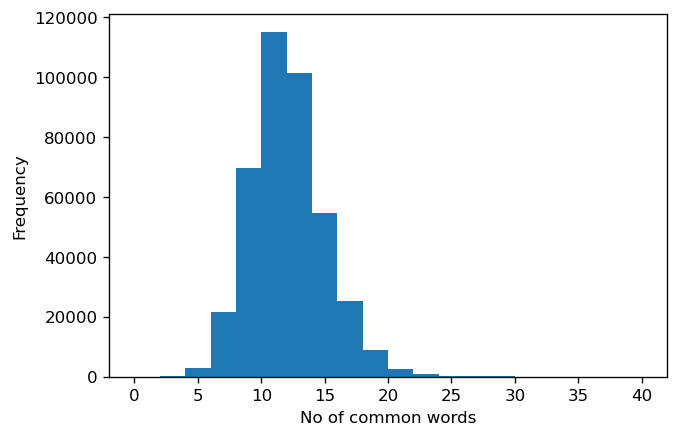

In [66]:
plt.hist(common_word, bins=20)
#plt.title('Distribution of the common words between the questions pairs')
plt.xlabel('No of common words')
plt.ylabel('Frequency')

In [61]:
common_token = df_model.apply(lambda x: count_common_word(x['question1_tokenize'], x['question2_tokenize']), axis=1)

Text(0, 0.5, 'Frequency')

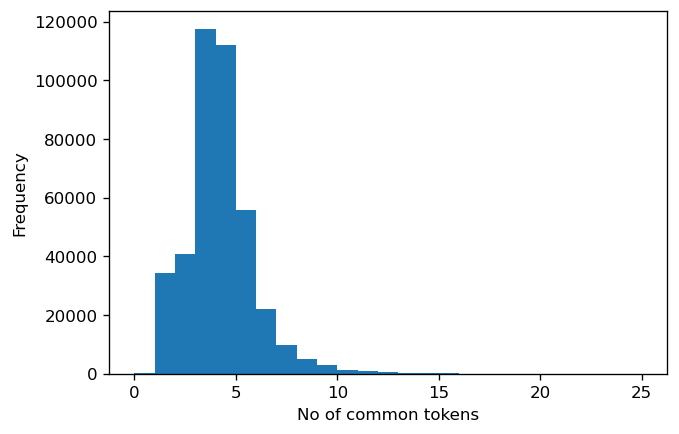

In [68]:
plt.hist(common_token, bins=25)
#plt.title('Distribution of the common words between the questions pairs')
plt.xlabel('No of common tokens')
plt.ylabel('Frequency')

Text(0, 0.5, 'No of common words')

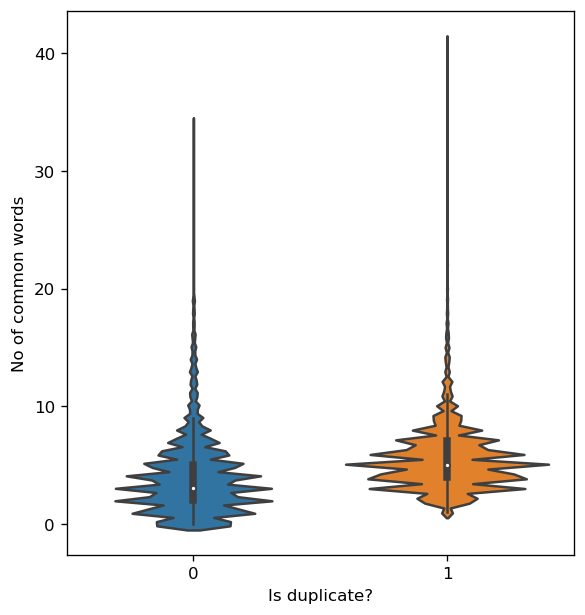

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate',y='word_common',data=df_model)
plt.xlabel('Is duplicate?')
plt.ylabel('No of common words')

Text(0, 0.5, 'No of common tokens')

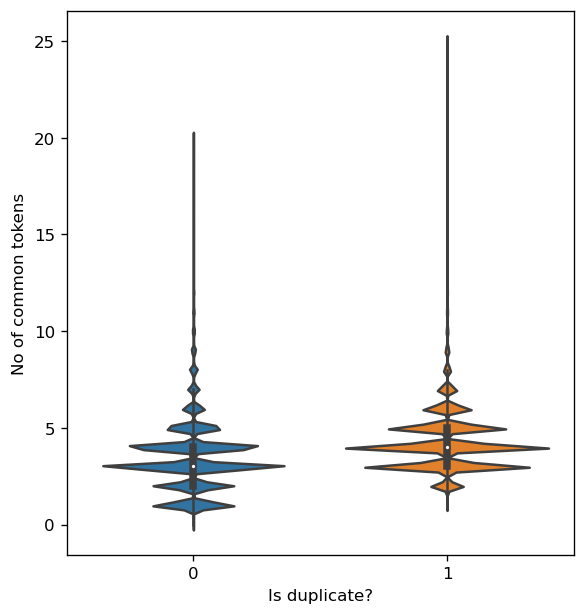

In [81]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate',y=common_token,data=df_model)
plt.xlabel('Is duplicate?')
plt.ylabel('No of common tokens')

Text(0, 0.5, 'No of common words / Total no of words')

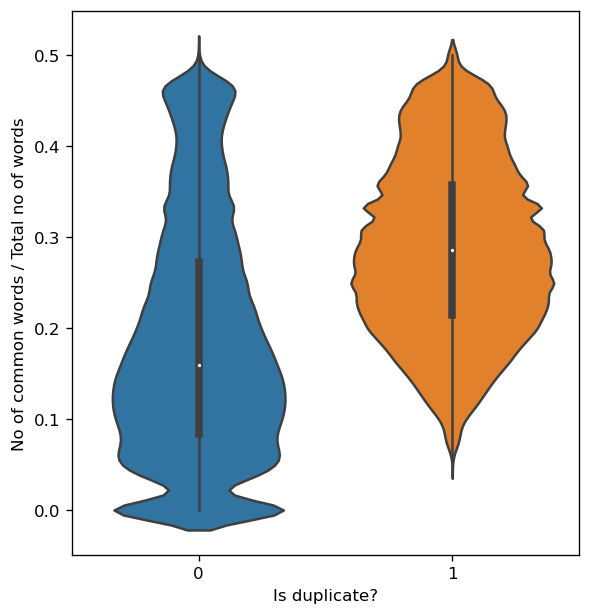

In [76]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate',y='word_share',data=df_model)
plt.xlabel('Is duplicate?')
plt.ylabel('No of common words / Total no of words')

In [83]:
def count_token_ratio(q1, q2):
    q1_words = set([word for word in q1 if word not in stop_words])
    q2_words = set([word for word in q2 if word not in stop_words])
    return count_common_word(q1, q2) / (len(q1_words) + len(q2_words))

In [84]:
common_token_ratio = df_model.apply(lambda x: count_token_ratio(x['question1_tokenize'], x['question2_tokenize']), axis=1)

Text(0, 0.5, 'No of common tokens / Total no of tokens')

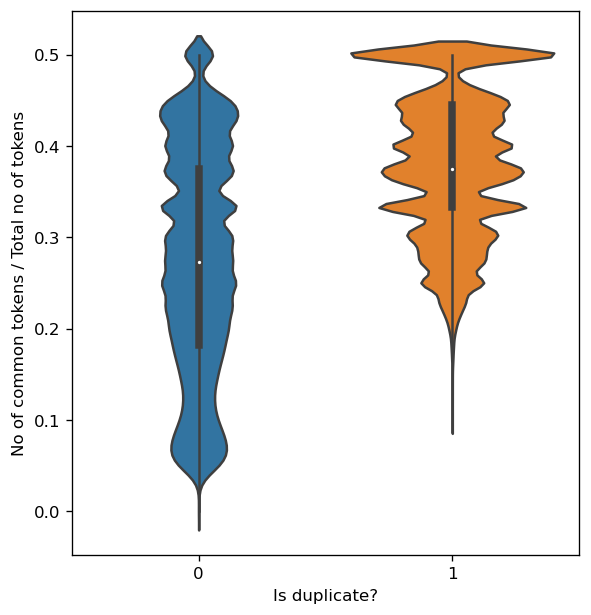

In [85]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate',y=common_token_ratio,data=df_model)
plt.xlabel('Is duplicate?')
plt.ylabel('No of common tokens / Total no of tokens')

### Feature Engineering

- tf-idf
- word2vec
- word count
- number of the same words in both questions
- ....

In [56]:
# merge texts
questions = list(df_model['question1']) + list(df_model['question2'])

tfidf = TfidfVectorizer(lowercase=False, )
tfidf.fit_transform(questions)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [64]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(df_model['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
df_model['q1_feats_m'] = list(vecs1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 404287/404287 [37:10<00:00, 181.26it/s]


In [66]:
vecs2 = []
for qu2 in tqdm(list(df_model['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc2), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
df_model['q2_feats_m'] = list(vecs2)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 404287/404287 [37:04<00:00, 181.75it/s]


In [67]:
df_model['q1_feats_m']

0         [18.807823797687888, 41.96485809981823, 33.081...
1         [-23.07975298911333, 14.342898577451706, -0.80...
2         [-0.11232639104127884, 18.1526191085577, 17.28...
3         [-22.97800123691559, 3.542212128639221, -21.20...
4         [47.606658816337585, 76.04556792974472, -16.10...
                                ...                        
404285    [9.178648501634598, 37.04424378275871, -4.0321...
404286    [-15.425078265368938, 24.70640254020691, -1.94...
404287    [1.947165310382843, 17.780263423919678, -4.203...
404288    [-10.663513448089361, 71.10905057191849, -3.58...
404289    [0.534325122833252, 28.80736929178238, 0.16547...
Name: q1_feats_m, Length: 404287, dtype: object

In [79]:
np_tdidf = np.concatenate([np.array(df_model.q1_feats_m.values.tolist()),np.array(df_model.q2_feats_m.values.tolist())],axis=1)

In [80]:
np_tdidf.shape

(404287, 192)

In [83]:
df_tdidf = pd.DataFrame(np_tdidf,columns=[f'tdidf_{i}' for i in range(np_tdidf.shape[1])])

In [84]:
df_tdidf

,tdidf_0,tdidf_1,tdidf_2,tdidf_3,tdidf_4,tdidf_5,tdidf_6,tdidf_7,tdidf_8,tdidf_9,...,tdidf_182,tdidf_183,tdidf_184,tdidf_185,tdidf_186,tdidf_187,tdidf_188,tdidf_189,tdidf_190,tdidf_191
0,18.807824,41.964858,33.081644,4.244245,43.027614,-10.013357,-10.744914,-11.815834,5.588284,1.115507,...,23.793527,-20.588515,-25.390726,12.380482,-19.671285,16.618804,30.438969,43.384315,5.521890,2.243517
1,-23.079753,14.342899,-0.805498,-19.245314,8.865766,-9.310463,-16.653137,-13.512737,3.500104,-3.910098,...,68.032480,1.352713,-25.395087,-7.580493,-23.430162,3.710800,1.435847,44.218931,11.410575,22.943352
2,-0.112326,18.152619,17.287420,23.381105,25.388403,-6.092745,-20.567560,-15.121486,-2.940619,16.324158,...,-10.696344,-35.324732,-20.233555,40.031745,-22.515536,12.892494,0.084753,21.583730,24.523884,-7.576810
3,-22.978001,3.542212,-21.203793,6.316199,11.723266,11.653449,-29.423859,2.754814,-17.613935,-12.570246,...,6.891576,-21.247961,0.394707,41.386888,-9.613209,18.265146,-1.723275,1.429064,18.121389,18.178995
4,47.606659,76.045568,-16.103148,25.784883,4.649413,-14.228690,-42.204369,32.545678,4.067263,-16.961604,...,17.671451,-11.538381,-11.433053,14.088320,-32.658980,6.244056,20.535041,17.647704,12.484855,-12.859798
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404282,9.178649,37.044244,-4.032192,-17.153661,25.205206,3.461860,-21.982398,11.458714,-1.416370,7.410309,...,4.159190,-29.015737,-3.858676,-29.471864,-4.945137,46.645847,-10.280123,10.133515,-12.078684,34.829898
404283,-15.425078,24.706403,-1.943462,10.030119,30.865222,1.757664,-5.835429,-3.081762,4.127655,-5.416119,...,5.680515,-8.920724,-4.585928,-1.465022,-19.351897,23.014452,-8.663755,-16.248009,16.850877,6.518227
404284,1.947165,17.780263,-4.203688,8.353560,4.135916,8.107851,-17.451527,16.427830,-4.281144,9.586498,...,-2.573912,5.437845,-6.158482,-10.986092,-16.752536,4.301796,-4.227480,5.879608,18.068287,-14.901856
404285,-10.663513,71.109051,-3.587024,5.822129,22.264445,-6.687319,-40.358158,-12.419938,1.507322,52.716891,...,0.578046,-49.756442,-59.002759,11.332621,-68.545367,40.523968,49.950863,45.276391,8.310787,-1.280904


In [86]:
df_model = pd.concat([df_model, df_tdidf], axis=1)

In [95]:
df_model = df_model.drop(['q1_feats_m', 'q2_feats_m'], axis=1)

In [96]:
df_model

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_common,word_total,word_share,freq_q1+q2,freq_q1-q2,question1_tokenize,question2_tokenize,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,tdidf_0,tdidf_1,tdidf_2,tdidf_3,tdidf_4,tdidf_5,tdidf_6,tdidf_7,tdidf_8,tdidf_9,tdidf_10,tdidf_11,tdidf_12,tdidf_13,tdidf_14,tdidf_15,tdidf_16,tdidf_17,tdidf_18,tdidf_19,tdidf_20,tdidf_21,tdidf_22,tdidf_23,tdidf_24,tdidf_25,tdidf_26,tdidf_27,tdidf_28,tdidf_29,tdidf_30,tdidf_31,tdidf_32,tdidf_33,tdidf_34,tdidf_35,tdidf_36,tdidf_37,tdidf_38,tdidf_39,tdidf_40,tdidf_41,tdidf_42,tdidf_43,tdidf_44,tdidf_45,tdidf_46,tdidf_47,tdidf_48,tdidf_49,tdidf_50,tdidf_51,tdidf_52,tdidf_53,tdidf_54,tdidf_55,tdidf_56,tdidf_57,tdidf_58,tdidf_59,tdidf_60,tdidf_61,tdidf_62,tdidf_63,tdidf_64,tdidf_65,tdidf_66,tdidf_67,tdidf_68,tdidf_69,tdidf_70,tdidf_71,tdidf_72,tdidf_73,tdidf_74,tdidf_75,tdidf_76,tdidf_77,tdidf_78,tdidf_79,tdidf_80,tdidf_81,tdidf_82,tdidf_83,tdidf_84,tdidf_85,tdidf_86,tdidf_87,tdidf_88,tdidf_89,tdidf_90,tdidf_91,tdidf_92,tdidf_93,tdidf_94,tdidf_95,tdidf_96,tdidf_97,tdidf_98,tdidf_99,tdidf_100,tdidf_101,tdidf_102,tdidf_103,tdidf_104,tdidf_105,tdidf_106,tdidf_107,tdidf_108,tdidf_109,tdidf_110,tdidf_111,tdidf_112,tdidf_113,tdidf_114,tdidf_115,tdidf_116,tdidf_117,tdidf_118,tdidf_119,tdidf_120,tdidf_121,tdidf_122,tdidf_123,tdidf_124,tdidf_125,tdidf_126,tdidf_127,tdidf_128,tdidf_129,tdidf_130,tdidf_131,tdidf_132,tdidf_133,tdidf_134,tdidf_135,tdidf_136,tdidf_137,tdidf_138,tdidf_139,tdidf_140,tdidf_141,tdidf_142,tdidf_143,tdidf_144,tdidf_145,tdidf_146,tdidf_147,tdidf_148,tdidf_149,tdidf_150,tdidf_151,tdidf_152,tdidf_153,tdidf_154,tdidf_155,tdidf_156,tdidf_157,tdidf_158,tdidf_159,tdidf_160,tdidf_161,tdidf_162,tdidf_163,tdidf_164,tdidf_165,tdidf_166,tdidf_167,tdidf_168,tdidf_169,tdidf_170,tdidf_171,tdidf_172,tdidf_173,tdidf_174,tdidf_175,tdidf_176,tdidf_177,tdidf_178,tdidf_179,tdidf_180,tdidf_181,tdidf_182,tdidf_183,tdidf_184,tdidf_185,tdidf_186,tdidf_187,tdidf_188,tdidf_189,tdidf_190,tdidf_191
0,0.0,1.0,2.0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0.0,1.0,1.0,66.0,57.0,14.0,12.0,10.0,23.0,0.434783,2.0,0.0,"[step, step, guid, invest, share, market, indi...","[step, step, guid, invest, share, market, ]",0.833319,0.714276,0.999980,0.999980,0.833326,0.714281,0.0,1.0,2.0,13.0,100.0,93.0,93.0,98.0,0.965517,18.807824,41.964858,33.081644,4.244245,43.027614,-10.013357,-10.744914,-11.815834,5.588284,1.115507,-30.170084,-14.351320,41.116792,-7.119523,3.995967,33.354323,-17.730944,5.780393,1.179608,31.968379,-13.365348,-21.448225,0.158826,26.865440,3.917031,6.164278,-48.380915,-51.427958,-5.240506,-29.813020,47.343491,-13.405041,23.369998,-20.407769,52.206585,-40.527661,3.913583,-20.964618,-9.969450,24.479733,-21.353528,-40.896076,4.871263,12.776786,-38.494769,-7.711000,-36.135508,-41.597447,65.922466,-11.392577,-15.133901,7.812485,-20.850897,1.058450,10.323407,-24.293006,-38.674469,10.414390,-2.161339,-26.870887,5.204462,-37.068663,20.469225,-23.657622,-10.948505,3.628947,-5.457772,-30.500613,1.938033,-42.096031,-14.017004,-22.719999,-16.798715,15.333135,8.758236,7.055754,-14.903748,16.649700,27.768037,-40.461602,54.995131,10.239546,14.740792,2.994080,2.752803,-30.065014,20.576211,-21.568772,-24.228445,14.157072,-16.261099,25.543985,25.480805,39.165051,3.834179,9.871825,18.710793,37.375936,45.405470,5.427006,33.751087,-3.253411,-4.959901,-13.442779,3.905698,4.777377,-22.148543,-8.397876,33.991805,-15.717423,0.769366,20.965538,-8.149176,-6.982945,-0.220294,34.898826,-13.520903,-20.837738,-1.247399,19.857070,5.311532,5.790612,-45.432595,-45.181854,0.781877,-22.808248,44.329990,-18.003015,16.850946,-31.704211,44.328688,-31.347574,-3.478976,-23.225434,-6.520577,20.683242,-13.918028,-34.093079,12.777202,7.638465,-38.681467,-3.1462

In [97]:
df_model.to_csv('model.csv',index=False,quoting=csv.QUOTE_NONNUMERIC)